https://github.com/AIMLModeling/HJM

https://github.com/omartinsky/HJM/blob/main/hjm.ipynb

The Heath-Jarrow-Morton Model (HJM Model) is used to model forward interest rates using a differential equation that allows for randomness. I explained the assumptions of HJM model, then demonstrated how to calibrate and use it for security pricing in Python. https://www.youtube.com/watch?v=Pky6sUat0wE

In [80]:
# %pip install progressbar2

In [81]:
from mpl_toolkits.mplot3d import Axes3D
import copy as copylib
from progressbar import *
import pandas as pd
import numpy
#%pylab
from matplotlib import pylab
from pylab import *
pylab.rcParams['figure.figsize'] = (16, 4.5)
numpy.random.seed(0)

Readjusting treasury rate data to instantanious rates

An Instantaneous Forward Rate $f(t, T)$ is the theoretical interest rate for a loan of an infinitesimally short duration, starting at time $T$, as viewed from today ($t=0$).

In [82]:

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

In [83]:
""#df = pd.read_csv('./yield-curve-rates-1990-2024 (1).csv').set_index('Date') / 100

# convert column names
#def parse_tenor(col):
#    if 'Mo' in col:
#        return float(col.replace(' Mo', '')) / 12.0
#    elif 'Yr' in col:
#        return float(col.replace(' Yr', ''))
#    return np.nan
#tenors = np.array([parse_tenor(col) for col in df.columns])

# The maturities for which we have data, sorted
#maturities_df = pd.DataFrame({'Maturity': tenors, 'Column': df.columns}).dropna().sort_values('Maturity')

# Filter the original DataFrame to only include columns with valid, parseable maturities
#df_par_yields = df[maturities_df['Column']].copy()
#tenors = maturities_df['Maturity'].values""


tenors

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5, 30. ])

Plotting dataframe

C:\Users\Het Objectief\AppData\Local\Temp\ipykernel_35204\707518505.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw = pd.read_csv(file_path, index_col=0, parse_dates=True)



--- HJM Input Variabelen Gemaakt met Interpolatie ---
hist_rates matrix dimensie: (550, 61)
Looptijden (mc_tenors) bereik: 0.0Y tot 30.0Y
Stapgrootte looptijden: 0.5 jaar


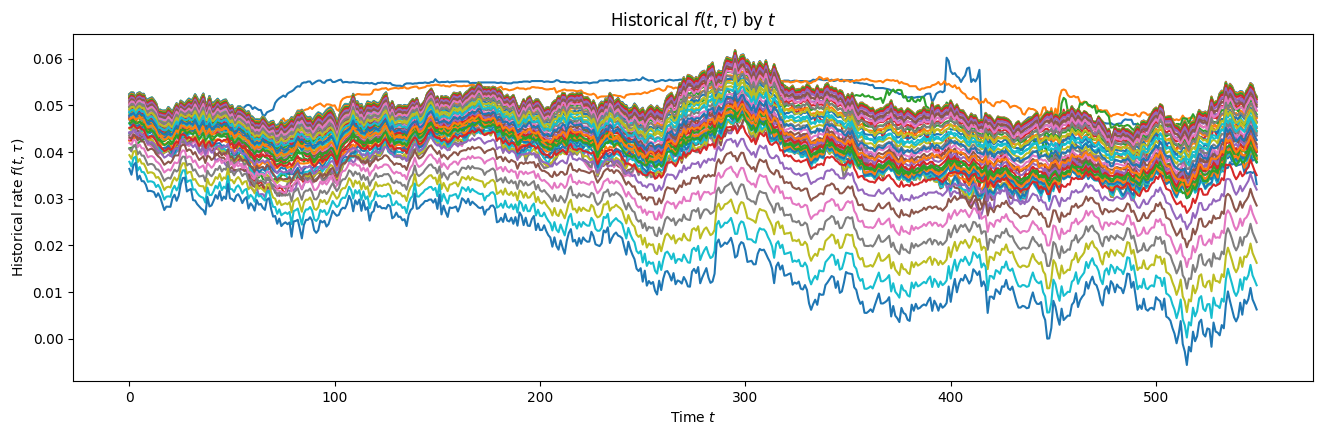

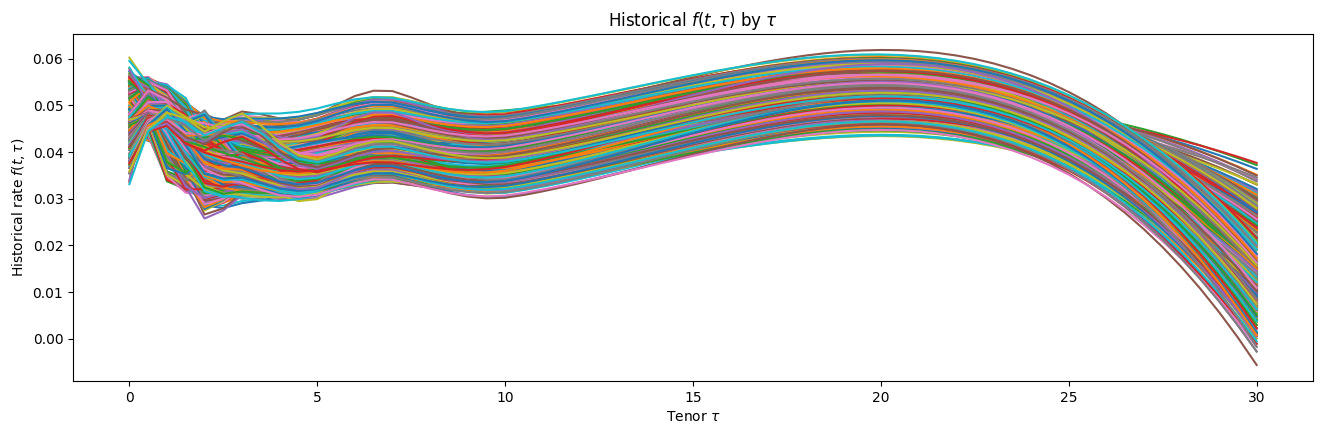

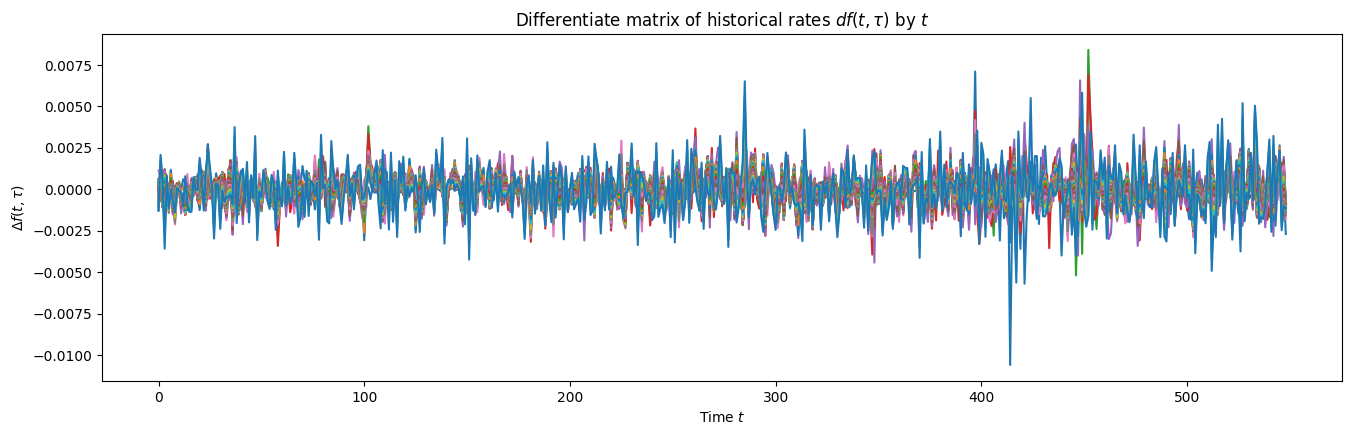

In [84]:
import pandas as pd
import numpy as np
from numpy import log, exp, diff, matrix, linspace
from pylab import plot, xlabel, ylabel, title, show, text, figure
from scipy.interpolate import CubicSpline

# --- STAP 1 & 2: Data Inlezen en Opschonen (Zoals eerder) ---
# ... (Deze stappen blijven hetzelfde: inlezen, kolommen opruimen, naar floats converteren) ...
# df_rates bevat de opgeschoonde Zero-Coupon Yields (ZCY) en tenors bevat de looptijden.

file_path = 'yield-curve-rates-1990-2024 (1).csv'
try:
    df_raw = pd.read_csv(file_path, index_col=0, parse_dates=True)
except Exception as e:
    df_raw = pd.read_csv(file_path, index_col=0)

def clean_tenor_name(col):
    col = str(col).upper().replace(' ', '')
    if 'MO' in col: return float(col.replace('MO', '')) / 12.0
    elif 'YR' in col: return float(col.replace('YR', ''))
    elif 'DAY' in col: return float(col.replace('DAY', '')) / 365.0
    try: return float(col)
    except ValueError: return np.nan

new_cols = [clean_tenor_name(col) for col in df_raw.columns]
valid_cols = [i for i, x in enumerate(new_cols) if not np.isnan(x)]
df_rates = df_raw.iloc[:, valid_cols].copy()
df_rates.columns = [new_cols[i] for i in valid_cols]

df_rates = df_rates.apply(pd.to_numeric, errors='coerce')
if df_rates.iloc[0, 0] > 1.0: df_rates = df_rates / 100.0
df_rates.dropna(axis=0, how='any', inplace=True) 
df_rates = df_rates.sort_index(axis=1)

# Originele looptijden uit de data
original_tenors = np.array(df_rates.columns)


# --- STAP 3: Interpolatie naar Gelijkmatig Grid (Halfjaarlijks) ---

MAX_YEARS = 30.0 # Maximale looptijd voor de simulatie
# Maak het nieuwe, gelijkmatige grid: van 0.5 tot 30 jaar, met stappen van 0.5 jaar.
# We voegen 0 toe als startpunt voor de korte rente.
mc_tenors_half_yearly = linspace(0.5, MAX_YEARS, int(MAX_YEARS / 0.5))
mc_tenors_half_yearly = np.insert(mc_tenors_half_yearly, 0, 0.0) # r(t) op t=0

hist_rates_interpolated_zcy = []

for index, zcy_rates in df_rates.iterrows():
    # ZCY-tarieven op de ongelijke looptijden
    y_orig = zcy_rates.values
    x_orig = original_tenors
    
    # Gebruik CubicSpline om te interpoleren
    # Interpoleren van de ZCY's is numeriek stabieler dan direct IFR
    cs = CubicSpline(x_orig, y_orig, extrapolate=True)
    
    # Bereken de ZCY-tarieven op het nieuwe halfjaarlijkse grid
    interpolated_zcy_curve = cs(mc_tenors_half_yearly)
    
    # Belangrijke Aanname: De kortste beschikbare rate (op t=0) is de korte rente r(t)
    # De IFR-conversie start vanaf hier, dus we zorgen dat de 0-tenor correct is.
    interpolated_zcy_curve[0] = y_orig[0] # Gebruik de kortste oorspronkelijke rate voor T=0
    
    hist_rates_interpolated_zcy.append(interpolated_zcy_curve)


# --- STAP 4: Conversie van Geïnterpoleerde ZCY naar Instantane Forward Rates (IFR) ---

hist_rates_ifr = []

for zcy_curve in hist_rates_interpolated_zcy:
    T = mc_tenors_half_yearly
    Z = zcy_curve
    
    # Berekening van T * Z (Zero-Rate * Looptijd)
    TZ = Z * T
    
    # Numerieke afgeleide (helling): f(t, Ti) = d(TZ) / dT
    dTZ = np.diff(TZ)
    dT = np.diff(T) # In ons geval is dT constant (0.5 jaar)
    
    # De IFR is de helling tussen twee punten
    ifr_segment = dTZ / dT
    
    # Instantane Korte Rente: f(t, 0) is de eerste ZCY-rate
    r_t = Z[0] 
    
    # De IFR-curve heeft één punt minder dan de ZCY-curve (omdat het een helling is).
    # We voegen de korte rente r(t) toe als eerste punt om de lengte te matchen.
    full_ifr_curve = np.insert(ifr_segment, 0, r_t)
    
    hist_rates_ifr.append(full_ifr_curve)


# --- STAP 5: De Finale HJM Input Variabelen Creëren ---

# De looptijden zijn nu het nieuwe, gelijkmatige grid
tenors = mc_tenors_half_yearly
dataframe = pd.DataFrame(hist_rates_ifr, index=df_rates.index, columns=tenors)

# De uiteindelijke variabelen voor de rest van de code:
hist_timeline = list(dataframe.index)
hist_rates = matrix(dataframe)

# Controleren of we 30 jaar bereikt hebben:
mc_tenors = tenors # Nu is mc_tenors de variabele met de juiste looptijden

print("\n--- HJM Input Variabelen Gemaakt met Interpolatie ---")
print(f"hist_rates matrix dimensie: {hist_rates.shape}")
print(f"Looptijden (mc_tenors) bereik: {mc_tenors[0]:.1f}Y tot {mc_tenors[-1]:.1f}Y")
print(f"Stapgrootte looptijden: {mc_tenors[1] - mc_tenors[0]:.1f} jaar")


# --- STAP 6: De Plotting Code Uitvoeren (om te controleren) ---

# ... (De plotting code is nu correct omdat de data de IFR's op het halfjaarlijkse grid bevat) ...
# De rest van de plotting code die je gaf:
figure()
plot(hist_rates), xlabel(r'Time $t$'), 
ylabel(r'Historical rate $f(t,\tau)$'), 
title(r'Historical $f(t,\tau)$ by $t$'), show();

figure()
plot(mc_tenors, hist_rates.transpose()), xlabel(r'Tenor $\tau$'), 
ylabel(r'Historical rate $f(t,\tau)$'),
title(r'Historical $f(t,\tau)$ by $\tau$'), show();

diff_rates = diff(hist_rates, axis=0)
assert(hist_rates.shape[1]==diff_rates.shape[1])
figure()
plot(diff_rates), xlabel(r'Time $t$'), 
ylabel(r'$\Delta f(t,\tau)$'),
title(r'Differentiate matrix of historical rates $df(t,\tau)$ by $t$'), show();

In [85]:
dataframe.head()

,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,25.5,26.0,26.5,27.0,27.5,28.0,28.5,29.0,29.5,30.0
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-31,0.0440,0.0424,0.0408,0.042612,0.044188,0.043458,0.042742,0.043641,0.045002,0.046195,...,0.046981,0.046120,0.045186,0.044174,0.043084,0.041912,0.040657,0.039317,0.037888,0.036370
2024-12-30,0.0443,0.0425,0.0409,0.042468,0.043732,0.043925,0.043875,0.044187,0.044633,0.045122,...,0.047301,0.046342,0.045291,0.044146,0.042903,0.041560,0.040113,0.038559,0.036896,0.035121
2024-12-27,0.0444,0.0429,0.0411,0.043670,0.044730,0.044677,0.044523,0.044980,0.045605,0.046178,...,0.047596,0.046761,0.045851,0.044863,0.043797,0.042648,0.041416,0.040097,0.038690,0.037191
2024-12-26,0.0445,0.0431,0.0415,0.043341,0.044059,0.044400,0.044600,0.044837,0.045090,0.045368,...,0.046866,0.046117,0.045304,0.044425,0.043478,0.042462,0.041374,0.040213,0.038977,0.037663
2024-12-24,0.0444,0.0430,0.0418,0.043142,0.043658,0.044640,0.045360,0.045355,0.045191,0.045219,...,0.047137,0.046127,0.045015,0.043798,0.042472,0.041033,0.039478,0.037803,0.036004,0.034079


In [86]:

#dataframe =  pd.read_csv('hjm_data.csv').set_index('time') / 100 # Convert interest rates to %
#pd.options.display.max_rows = 10
#display(dataframe)
#dataframe = df_forward_rates.copy()

#hist_timeline = list(dataframe.index)
#tenors = [eval(x) for x in dataframe.columns]
#hist_rates = matrix(dataframe)

#plot(hist_rates), xlabel(r'Time $t$'), 
#ylabel(r'Historical rate $f(t,\tau)$'), text(200, 0.065, r'Evolution of daily historical yield curve data with 51 tenors over 5 years. Each line represents a different tenor'),
#title(r'Historical $f(t,\tau)$ by $t$'), show();

#plot(tenors, hist_rates.transpose()), xlabel(r'Tenor $\tau$'), 
#ylabel(r'Historical rate $f(t,\tau)$'), text(3, 0.066, r'Evolution of daily historical yield curve data with 51 tenors over 5 years. Each line represents different day in the past'),
#title(r'Historical $f(t,\tau)$ by $\tau$'), show();

#diff_rates = diff(hist_rates, axis=0)
#assert(hist_rates.shape[1]==diff_rates.shape[1])
#plot(diff_rates), xlabel(r'Time $t$'), title(r'Differentiate matrix of historical rates $df(t,\tau)$ by $t$'), show();

Calculating PCA

Sigma shape : (61, 61)
Eigenvalues :
[ 5.84245670e-03+0.00000000e+00j  2.78435480e-03+0.00000000e+00j
  7.79032212e-04+0.00000000e+00j  4.26302251e-04+0.00000000e+00j
  3.04323918e-04+0.00000000e+00j  1.97714495e-04+0.00000000e+00j
  1.75122735e-04+0.00000000e+00j  1.08686219e-05+0.00000000e+00j
  5.14815828e-05+0.00000000e+00j  1.09143252e-04+0.00000000e+00j
  1.02961451e-04+0.00000000e+00j -4.44546095e-19+4.29860890e-21j
 -4.44546095e-19-4.29860890e-21j  4.31576892e-19+0.00000000e+00j
 -3.96618673e-19+0.00000000e+00j -3.87490787e-19+0.00000000e+00j
 -3.36171075e-19+0.00000000e+00j  3.88775633e-19+0.00000000e+00j
  3.79725696e-19+0.00000000e+00j  3.59954776e-19+0.00000000e+00j
 -3.15758077e-19+0.00000000e+00j -2.95449039e-19+0.00000000e+00j
  3.29138976e-19+0.00000000e+00j -2.70989187e-19+0.00000000e+00j
 -2.37543661e-19+0.00000000e+00j -2.28087058e-19+0.00000000e+00j
 -2.22547699e-19+6.21806910e-21j -2.22547699e-19-6.21806910e-21j
  3.03215648e-19+0.00000000e+00j  2.86797059e-19+0.00

C:\Users\Het Objectief\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


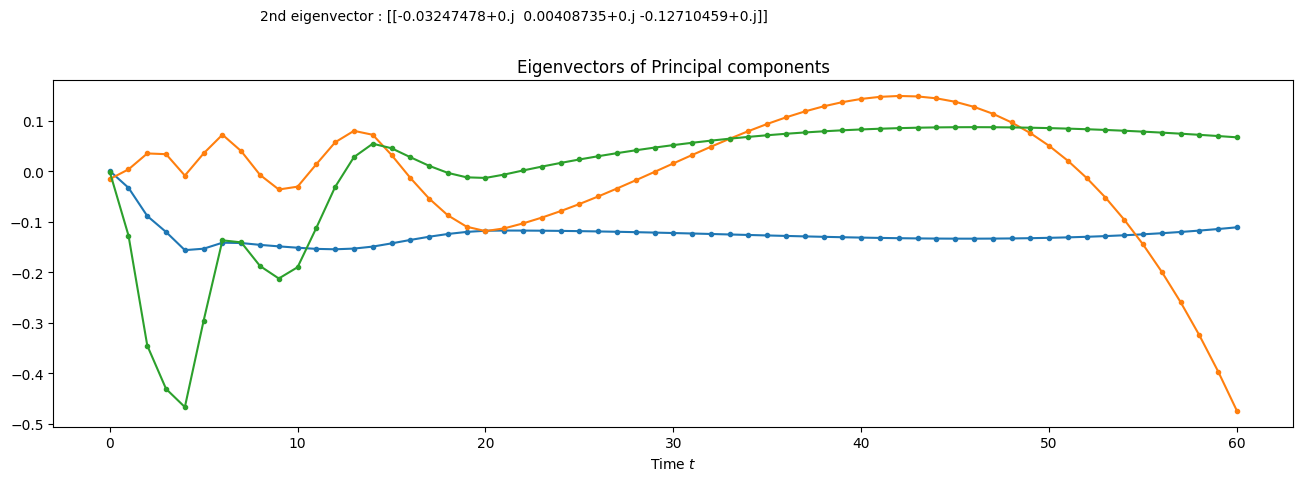

In [87]:
# Calculate covariance matrix
sigma = cov(diff_rates.transpose())
print("Sigma shape : " + str(sigma.shape))
sigma *= 252 # 252 trading days in a year
eigval, eigvec = linalg.eig(sigma) # Eigenvectors represent the principal axes of variance, and eigenvalues represent the magnitude of that variance.
eigvec=matrix(eigvec)
assert type(eigval) == ndarray # assert checks if a condition is true
assert type(eigvec) == matrix
print("Eigenvalues :")
print(eigval)
factors=3 # Sets the number of principal components to keep
index_eigvec = list(reversed(eigval.argsort()))[0:factors]   # selects 3 highest principal component first in the array
princ_eigval = array([eigval[i] for i in index_eigvec])
princ_comp = hstack([eigvec[:,i] for i in index_eigvec]) # horizontally rearrange eigenvalues

print("Principal eigenvalues")
print(princ_eigval)
print()
print("Principal eigenvectors")
print(princ_comp)
print()
eigenvector1_text=str(princ_comp[1])
print("eigenvectors of PC1", eigenvector1_text)

plot(princ_comp, marker='.'), title('Eigenvectors of Principal components'), 
xlabel(r'Time $t$'), text(8, 0.3, '2nd eigenvector : {}'.format(eigenvector1_text)),show();

An eigenvector e_i is a vector, or a one-dimensional array, that defines the shape of the i-th principal component (PC) and variance = eigenvalue(lambda)

Thus volatility(sigma) = sqrt(eigenvalue) * eigenvector

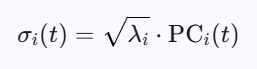

vols shape: (61, 3)


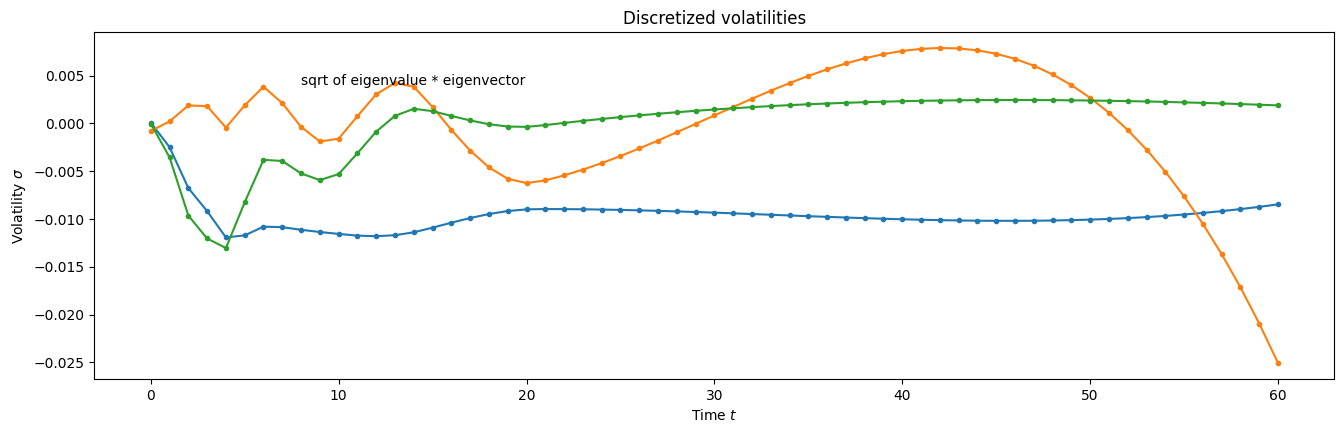

In [88]:
sqrt_eigval = matrix(princ_eigval ** .5) # volatility(sigma) = sqroot(var) = sqrt(eigenvalue)
tmp_m = vstack([sqrt_eigval for i in range(princ_comp.shape[0])])  # resize matrix (1,factors) to (n, factors)
vols = multiply(tmp_m, princ_comp) # multiply matrice element-wise
print('vols shape: ' + str(vols.shape))
plot(vols, marker='.'), title('Discretized volatilities'),
xlabel(r'Time $t$'), ylabel(r'Volatility $\sigma$'), text(8, 0.004, 'sqrt of eigenvalue * eigenvector'), show();


Polynomiaal example:

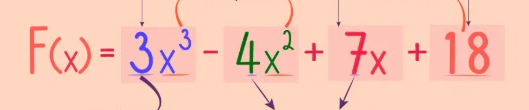

fitten (smoothing) van de volatiliteit: overbruggen van de kloof tussen historische data en een continu-tijd financiële model

C:\Users\Het Objectief\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)


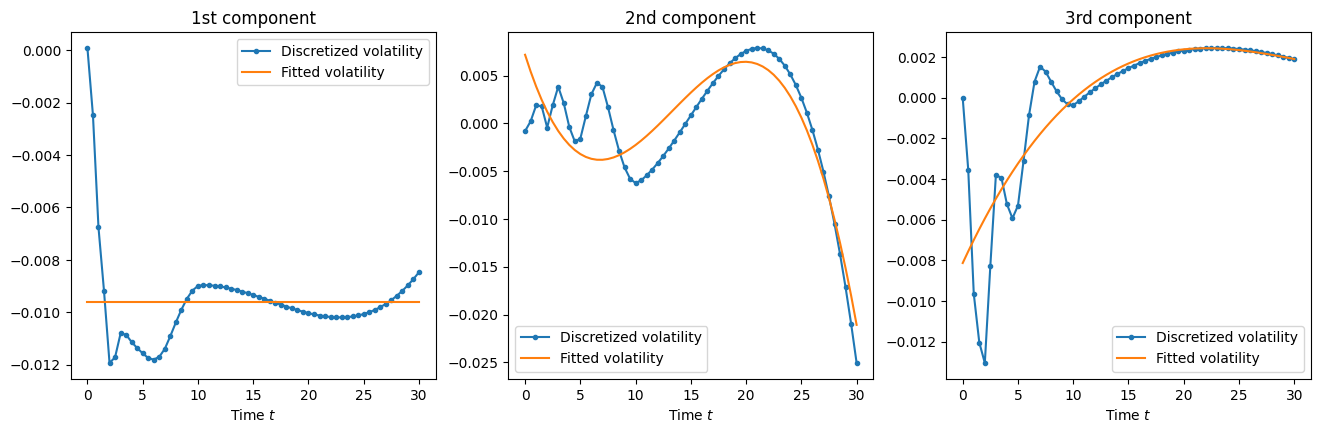

In [89]:
def get_matrix_column(mat, i):
    return array(mat[:,i].flatten())[0]

class PolynomialInterpolator:
    def __init__(self, params):
        assert type(params) == ndarray
        self.params = params
    def calc(self, x):
        n = len(self.params)
        C = self.params
        X = array([x**i for i in reversed(range(n))])
        return sum(multiply(X, C)) # geeft in de vorm P(x) = C_n x^n + .. + C_1 x^1 + C_0 weer
    
fitted_vols = []
def fit_volatility(i, degree, title):
    vol = get_matrix_column(vols, i)
    fitted_vol = PolynomialInterpolator(polyfit(tenors, vol, degree))    # polyfit(...) berekent de coëfficiënten (C's), PolynomialInterpolator polynomiale curve geeft formule
    plot(tenors, vol, marker='.', label='Discretized volatility')
    plot(tenors, [fitted_vol.calc(x) for x in tenors], label='Fitted volatility')
    plt.title(title), xlabel(r'Time $t$'), legend();
    fitted_vols.append(fitted_vol)
    
subplot(1, 3, 1), fit_volatility(0, 0, '1st component');
subplot(1, 3, 2), fit_volatility(1, 3, '2nd component');
subplot(1, 3, 3), fit_volatility(2, 3, '3rd component'); # 0, 3 en 3 weerspiegelen een empirische best practice
show()

aanpassen van 25 mc_tenors = linspace(0,25,51)

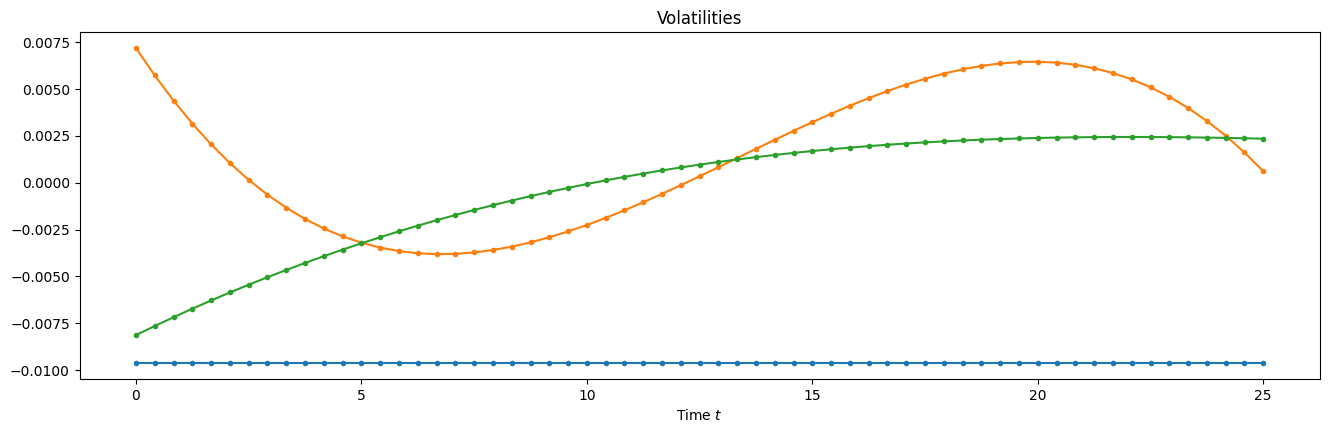

In [90]:
mc_tenors = linspace(0,25,61) # Deze array vertegenwoordigt een nieuw, fijnmazig rooster van looptijden (tenors), van 0 jaar tot 25 jaar. De oorspronkelijke historische data had mogelijk slechts 10-20 looptijden
# Discretize fitted volfuncs for the purpose of monte carlo simulation
# fitted_vol: de functies sigma_1(t), sigma_2(t), sigma_3(t), voor elke tijdseenheid
mc_vols = matrix([[fitted_vol.calc(tenor) for tenor in mc_tenors] for fitted_vol in fitted_vols]).transpose() # fitted_vol.calc(tenor) = f(tenor)
plot(mc_tenors, mc_vols, marker='.'), xlabel(r'Time $t$'), title('Volatilities'), show();


Drift (alfa)

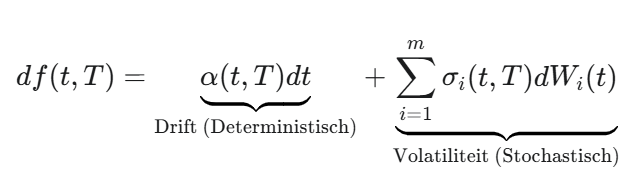
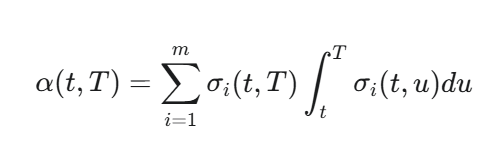

https://www.mdpi.com/2227-7390/9/2/114

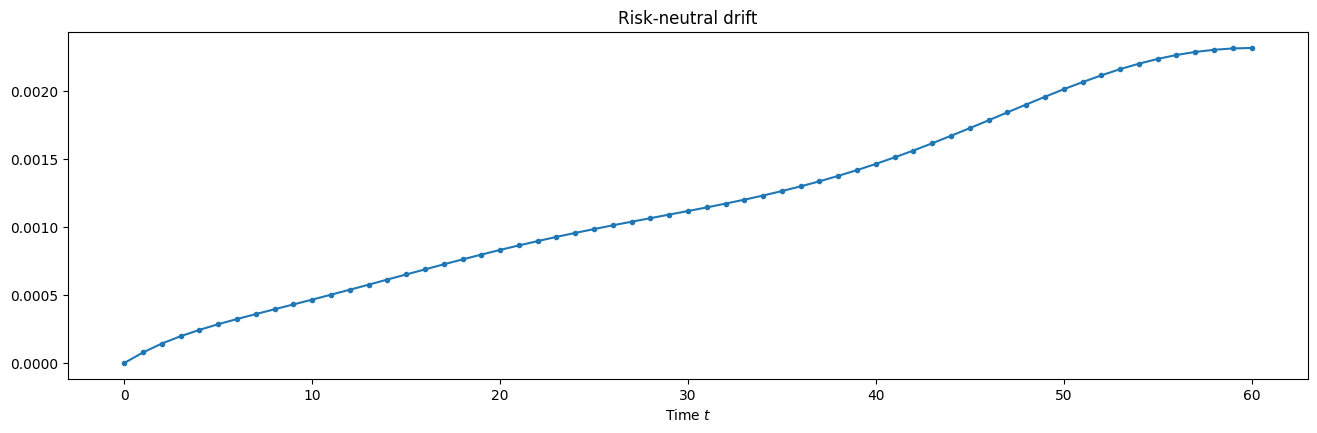

[0.0331     0.0445     0.0475     0.04647152 0.04352848 0.04515167
 0.04644833 0.04411621 0.04094226 0.03856043 0.0377811  0.03889482
 0.04025444 0.04111077 0.04113997 0.04026566 0.03928585 0.03848712
 0.03794158 0.03772133 0.03789846 0.03847149 0.03919004 0.0399755
 0.04081585 0.04169907 0.04261314 0.04354605 0.04448578 0.0454203
 0.0463376  0.04722565 0.04807245 0.04886597 0.0495942  0.05024511
 0.05080668 0.0512669  0.05161375 0.05183521 0.05191926 0.05185388
 0.05162706 0.05122677 0.050641   0.04985772 0.04886492 0.04765058
 0.04620269 0.04450921 0.04255814 0.04033746 0.03783514 0.03503917
 0.03193753 0.02851819 0.02476915 0.02067839 0.01623387 0.01142359
 0.00623553]
[ 0.          0.41666667  0.83333333  1.25        1.66666667  2.08333333
  2.5         2.91666667  3.33333333  3.75        4.16666667  4.58333333
  5.          5.41666667  5.83333333  6.25        6.66666667  7.08333333
  7.5         7.91666667  8.33333333  8.75        9.16666667  9.58333333
 10.         10.41666667 10

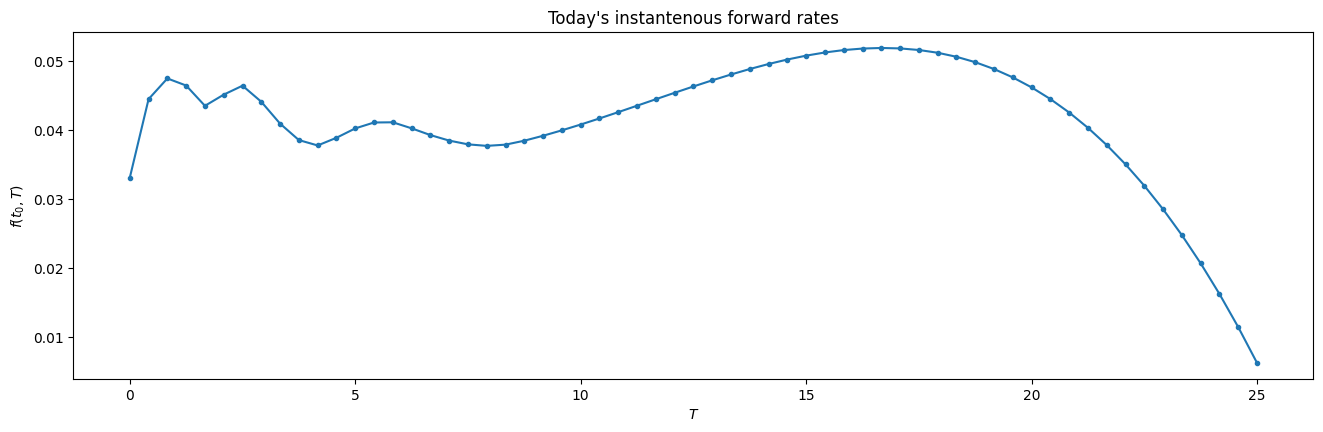

In [91]:
def integrate(f, x0, x1, dx): # simple trapezoidal rule integration
    n = (x1-x0)/dx+1
    out = 0
    for i, x in enumerate(linspace(x0, x1, int(n))):
        if i==0 or i==n-1:
            out += 0.5 * f(x)
        else:
            out += f(x)  # not adjusted by *0.5 because of repeating terms x1...xn-1 - see trapezoidal rule
    out *= dx
    return out

def integration_all(tau, fitted_vols):
    #This funciton carries out integration for all principal factors. 
    #It uses the fact that volatility is function of time in HJM model
    out = 0.
    for fitted_vol in fitted_vols:
        assert isinstance(fitted_vol, PolynomialInterpolator) # Als False is, stopt het en geeft AssertionError
        out += integrate(fitted_vol.calc, 0, tau, 0.01) * fitted_vol.calc(tau)
    return out

mc_drift = array([integration_all(tau, fitted_vols) for tau in mc_tenors])
plot(mc_drift, marker='.'), xlabel(r'Time $t$'), title('Risk-neutral drift'), show();

curve_spot = array(hist_rates[-1,:].flatten())[0] # yield curve (instantane forward rate curve) op de meest recente observatiedatum
print(curve_spot)
print(mc_tenors)
plot(mc_tenors, curve_spot.transpose(), marker='.'), ylabel('$f(t_0,T)$'), xlabel("$T$"), 
      

title('Today\'s instantenous forward rates'), show();

simuleert hoe de huidige rentes in de markt zich in de toekomst zullen ontwikkelen door kleine, stapsgewijze veranderingen toe te voegen, gebaseerd op drie krachten: de verwachte richting (drift), willekeurige schokken (volatiliteit), en een noodzakelijke wiskundige correctie (roll-down)

Om een SDE(stochastich diferentiaal vgl) op een computer te simuleren, moet je deze omzetten in een numerieke differentievergelijking over een kleine tijdstap $\Delta t$. De methode die je code gebruikt, is de Euler-Maruyama methode (de meest voorkomende methode voor SDE's).Jouw code implementeert de volgende vergelijking (waarbij $\Delta f$ de verandering is van $f$ over de tijdstap $\Delta t$):

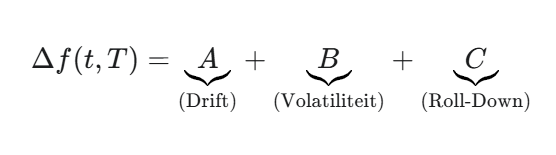
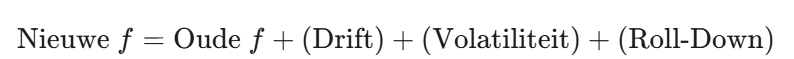

In [92]:
def simulation(f, tenors, drift, vols, timeline):
    assert type(tenors)==ndarray
    assert type(f)==ndarray
    assert type(drift)==ndarray
    assert type(timeline)==ndarray
    assert len(f)==len(tenors)
    vols = array(vols.transpose())  # 3 rows, T columns
    len_tenors = len(tenors)
    len_vols = len(vols)
    yield timeline[0], copylib.copy(f)
    for it in range(1, len(timeline)):
        t = timeline[it]
        dt = t - timeline[it-1]
        sqrt_dt = sqrt(dt)
        fprev = f
        f = copylib.copy(f)
        random_numbers = [normal() for i in range(len_vols)] # dW (Willekeurigheid)
        for iT in range(len_tenors):
            # Term 1: Deterministisch (Drift), verwachte verandering: Oude Waarde + alpha(T) dt
            val = fprev[iT] + drift[iT] * dt
            # Term 2: Stochastiek (Volatiliteit/Schok)
            sum = 0
            for iVol, vol in enumerate(vols):
                sum += vol[iT] * random_numbers[iVol]
            val += sum * sqrt_dt
            # Term 3: De Roll-Down (Looptijd Verschuiving)
            iT1 = iT+1 if iT<len_tenors-1 else iT-1   # if we can't take right difference, take left difference
            dfdT = (fprev[iT1] - fprev[iT]) / (iT1 - iT)
            val += dfdT * dt
            #
            f[iT] = val
        yield t,f

één enkel pad uit ter demonstratie

C:\Users\Het Objectief\AppData\Local\Temp\ipykernel_35204\1004038269.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  f[iT] = val


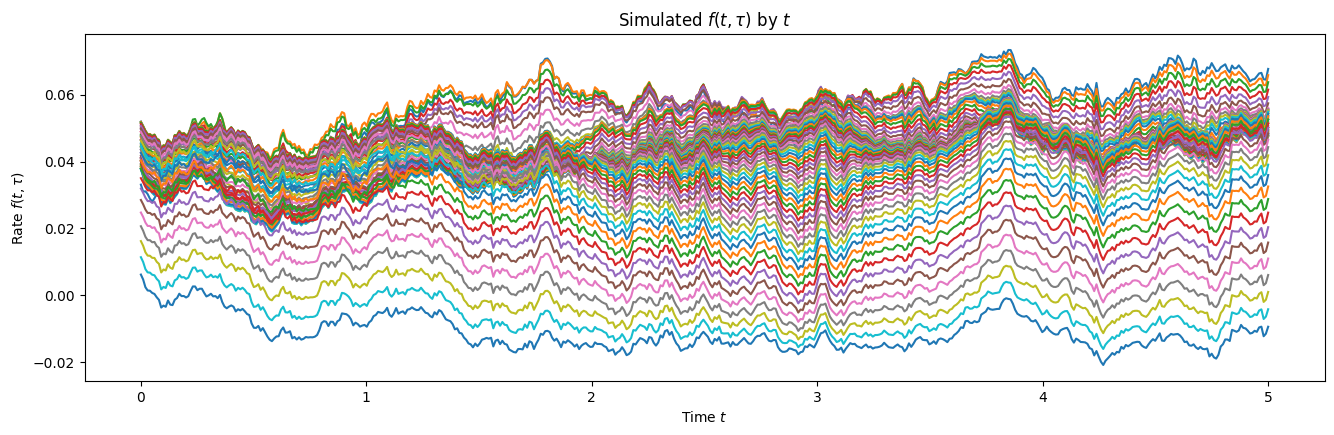

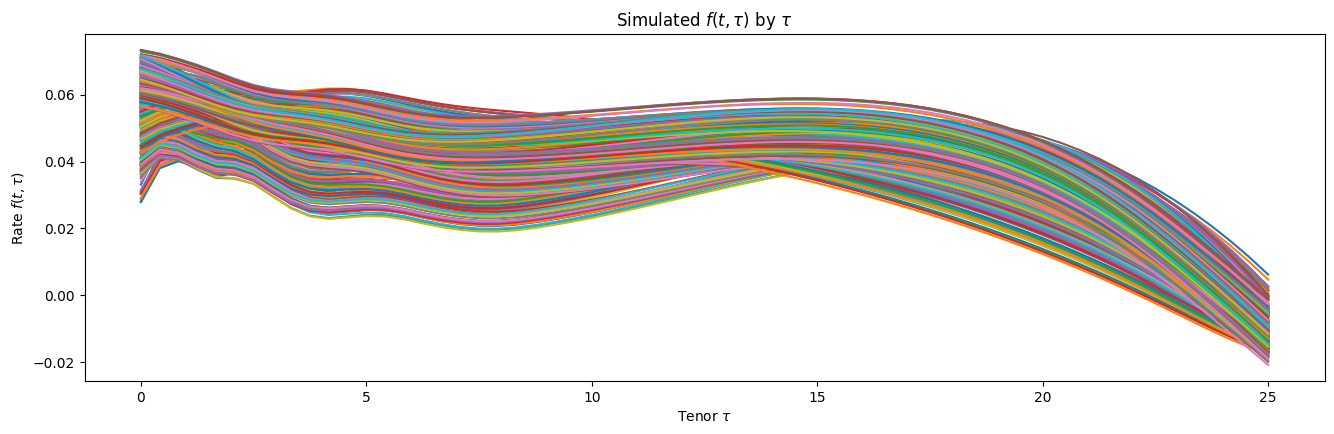

In [93]:
proj_rates = []
proj_timeline = linspace(0,5,500) # tijdsstappen voor de simulatie: over een periode van 5 jaar, verdeeld in 500 kleine stappen

for i, (t, f) in enumerate(simulation(curve_spot, mc_tenors, mc_drift, mc_vols, proj_timeline)):
    proj_rates.append(f)
proj_rates = matrix(proj_rates)
# voor elke maturity specifieke rente over tijd
plot(proj_timeline.transpose(), proj_rates), xlabel(r'Time $t$'), ylabel(r'Rate $f(t,\tau)$');
title(r'Simulated $f(t,\tau)$ by $t$'), show();
# yield curve voor elk tijdstip
plot(mc_tenors, proj_rates.transpose()), xlabel(r'Tenor $\tau$'), ylabel(r'Rate $f(t,\tau)$');
title(r'Simulated $f(t,\tau)$ by $\tau$'), show();

monte carlo simulaties (met gemini geschreven)

aanpassen van MAX_TIME

Start Monte Carlo simulatie van de rentecurve: 100 paden over 25.0 jaar.


C:\Users\Het Objectief\AppData\Local\Temp\ipykernel_35204\1004038269.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  f[iT] = val


Simulatie voltooid.


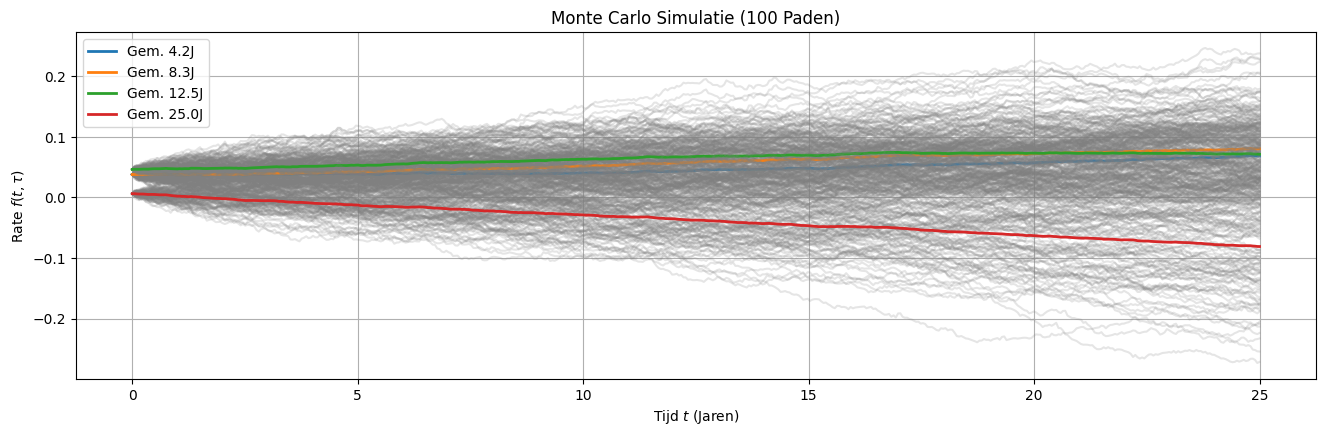

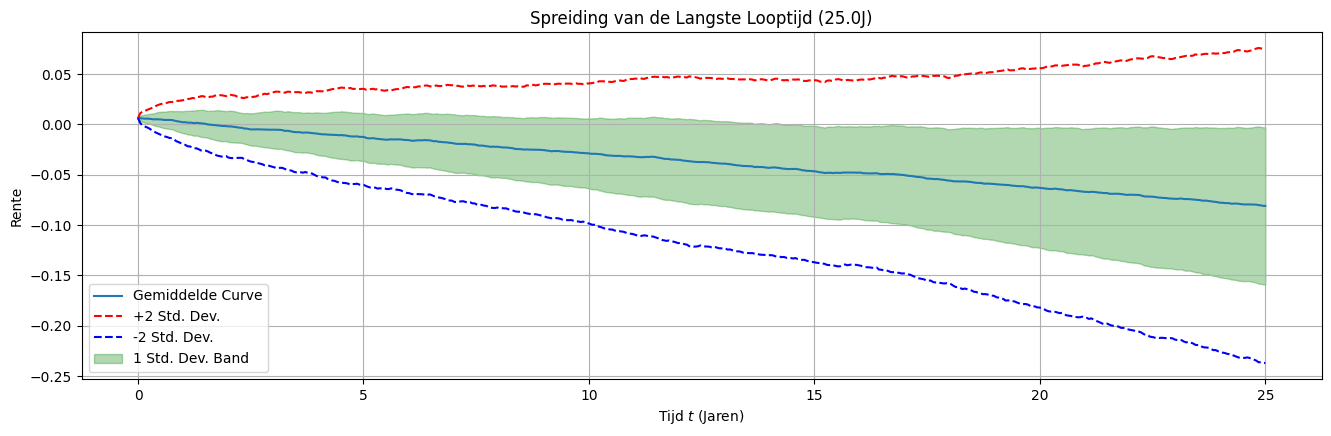

In [94]:
# --- Monte Carlo Simulatie van de Rente Curve ---

# Parameters voor de Monte Carlo run
N_SIMULATIONS = 100       # Het aantal paden dat je wilt simuleren
N_TIMESTEPS = 500         # Het aantal stappen in de tijd voor de nauwkeurigheid van elk pad
MAX_TIME = 25.0            # De periode waarover we simuleren (5 jaar)

# Definieer de tijdstappen
proj_timeline = linspace(0, MAX_TIME, N_TIMESTEPS)

# Lijst om ALLE 100 GESIMULEERDE PADEN op te slaan
# Dit zal een lijst van lijsten worden: [Paden] -> [Tijdstappen] -> [Tenors]
all_simulated_paths = []

print(f"Start Monte Carlo simulatie van de rentecurve: {N_SIMULATIONS} paden over {MAX_TIME} jaar.")

# 1. De Buitenste Monte Carlo Loop
for i in range(N_SIMULATIONS):
    # Lijst om de curve voor EEN ENKEL PAD op te slaan
    one_path_curves = []

    # 2. De Simulatie Loop (gebruikt de 'simulation' functie die je hebt gedefinieerd)
    # De generator produceert de curve in elke tijdstap.
    for t, curve_fwd in simulation(curve_spot, mc_tenors, mc_drift, mc_vols, proj_timeline):
        one_path_curves.append(curve_fwd)

    # Voeg het voltooide pad toe aan de totale resultaten
    all_simulated_paths.append(one_path_curves)

# Converteer de resultaten naar een NumPy array voor gemakkelijke manipulatie
# Dimensies: (N_SIMULATIONS, N_TIMESTEPS, len_tenors)
all_simulated_paths = array(all_simulated_paths)
print("Simulatie voltooid.")

# --- Visualisatie van de Monte Carlo Resultaten ---

# Selecteer een paar prominente looptijden (tenors) om te plotten
# We nemen de looptijd die overeenkomt met index 10, 20 en 30 (bijv. 5-jaar, 10-jaar, 15-jaar, afhankelijk van mc_tenors)
# Je kunt deze indices aanpassen
selected_tenor_indices = [10, 20, 30, -1] # De laatste index is de langste looptijd

figure()
# Plot de gesimuleerde paden voor verschillende looptijden (Time vs Rate)
for tenor_idx in selected_tenor_indices:
    # Haal de tijdreeks op voor die specifieke looptijd over alle simulaties
    # We plotten elke gesimuleerde pad voor deze ene looptijd
    tenor_rate_paths = all_simulated_paths[:, :, tenor_idx]

    # Plot alle 100 gesimuleerde paden in het grijs (alpha=0.2 maakt ze transparant)
    plot(proj_timeline, tenor_rate_paths.transpose(), color='gray', alpha=0.2)

    # Plot het gemiddelde van alle 100 paden in een duidelijke kleur
    avg_path = average(tenor_rate_paths, axis=0)
    plot(proj_timeline, avg_path, linewidth=2, label=f'Gem. {mc_tenors[tenor_idx]:.1f}J')

title(f'Monte Carlo Simulatie ({N_SIMULATIONS} Paden)')
xlabel(r'Tijd $t$ (Jaren)')
ylabel(r'Rate $f(t,\tau)$')
legend()
grid(True)
show()

# Om een betere visuele indruk te krijgen van de spreiding: Plot de spreiding (bandbreedte)
figure()
avg_path = average(all_simulated_paths[:, :, -1], axis=0) # Gemiddelde pad voor langste tenor
std_dev = std(all_simulated_paths[:, :, -1], axis=0) # Standaardafwijking voor langste tenor

plot(proj_timeline, avg_path, label='Gemiddelde Curve')
plot(proj_timeline, avg_path + 2 * std_dev, '--', color='red', label='+2 Std. Dev.')
plot(proj_timeline, avg_path - 2 * std_dev, '--', color='blue', label='-2 Std. Dev.')
fill_between(proj_timeline, avg_path - std_dev, avg_path + std_dev, color='green', alpha=0.3, label='1 Std. Dev. Band')

title(f'Spreiding van de Langste Looptijd ({mc_tenors[-1]:.1f}J)')
xlabel(r'Tijd $t$ (Jaren)')
ylabel('Rente')
legend()
grid(True)
show()